# Testing the surface tension idea

Question: what leads to the minimization of the contour length in self-aggregation studies.

Test two hypothesis: 

i)  Surface wind at the edge increases if the edge is further away from the center

ii) Stronger curvature leads to an on average drier surrounding and thus less deep convection 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [75]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cPickle
import os
from scipy.ndimage import gaussian_filter
from skimage.measure import label
from scipy.ndimage.measurements import center_of_mass
from datetime import timedelta
import netCDF4
import matplotlib.colors as colors
from copy import copy
from datetime import timedelta

In [ ]:
def calc_distance_smoothed(data, tresh, plot = False, dx = 1.0, longest_contour = True, output_contour = False, sigma = 5, calc_Mi = True):
    
    # 1.st iteration to find rough estimate of center point Mi 
    data_1 = gaussian_filter(data, sigma = sigma)
    
    if len(np.where(data_1>tresh)[0])<10: 
        
        print('no moist convecting area was found')
        
        if output_contour:
            return np.nan, (np.nan, np.nan), np.nan, np.nan
        else:
            return np.nan, (np.nan, np.nan)
    else:   
        
        if output_contour:
            nope, Mi_1, x_edge, y_edge = calc_distance(data_1, tresh, plot = plot, dx = dx, longest_contour = longest_contour, output_contour = output_contour, calc_Mi = calc_Mi)
        else:
            nope, Mi_1 = calc_distance(data_1, tresh, plot = plot, dx = dx, longest_contour = longest_contour, output_contour = output_contour, calc_Mi = calc_Mi)

        # Roll data to estimated first center and apply smoothing
        if calc_Mi:
            data = roll_to_center(data, Mi_1)
        data = gaussian_filter(data, sigma = sigma)

        if output_contour: 
            distance_min, Mi_adjusted, x_edge, y_edge = calc_distance(data, tresh, plot = plot, dx = dx, longest_contour = longest_contour, output_contour = output_contour, calc_Mi = calc_Mi)
        else:
            distance_min, Mi_adjusted = calc_distance(data, tresh, plot = plot, dx = dx, longest_contour = longest_contour, output_contour = output_contour, calc_Mi = calc_Mi)

        (Ly, Lx) = np.shape(data)
        Mi_feld = [(Ly-1)/2, (Lx-1)/2]

        Mi = [np.nan, np.nan]

        if calc_Mi:
            Mi[0] = Mi_1[0] - (Mi_feld[0] - Mi_adjusted[0])
            Mi[1] = Mi_1[1] - (Mi_feld[1] - Mi_adjusted[1])

        if output_contour:
            return distance_min, Mi, x_edge, y_edge

        else:
            return distance_min, Mi

In [77]:
# day_start, hour_start = 150, 0
# day_end,   hour_end   = 600, 0

# tresh = 60.0
# tresh2 = 0.01
# dx = 3.0

# time_step_h = 12
# time_s_step = timedelta(days=0, hours = time_step_h).total_seconds()
# time_mean_h = 12
# time_s_mean = timedelta(days=0, hours = time_mean_h).total_seconds()

# time_s_start = timedelta(days=day_start, hours = hour_start).total_seconds()
# time_s_end   = timedelta(days=day_end, hours = hour_end).total_seconds()

# time_out_A = np.arange(time_s_start, time_s_end, time_s_step)  

# distance_A = np.ones((len(time_out_A), np.shape(wvp_A)[1], np.shape(wvp_A)[1]))
# v_h_abs_rolled_A = np.copy(distance_A)
# wvp_rolled_A = np.copy(distance_A)
# r_rolled_A = np.copy(distance_A)

# for i_t in range(len(time_out_A)):

#     time_s = time_out_A[i_t]
#     time_s_min, time_s_max = time_s - 2*time_s_mean , time_s
    
#     if i_t%50==0:
#         print(time_s/(3600.0*24), time_s_min/(3600.0*24))

#     i_analysis = np.where(time_wvp_A >= time_s_max)[0][0]
#     i_analysis_min  = np.where(time_wvp_A >= time_s_min)[0][0]

# #     if time_r_A[i_analysis] != time_wvp_A[i_analysis]:
# #         print('offset in time')
        
#     #Find edge of field
#     wvp_m  = np.mean(wvp_A[i_analysis_min:i_analysis,:,:], axis = 0)
#     distance_min, Mi = calc_distance_smoothed(wvp_m, tresh, sigma = 0, dx = dx)
    
#     distance_A[i_t,:,:] = distance_min
    
#     v_h_abs_m    = np.mean(v_h_abs_A[i_analysis_min:i_analysis,:,:], axis = 0)
#     v_h_abs_rolled = roll_to_center(v_h_abs_m, Mi)
#     v_h_abs_rolled_A[i_t,:,:] = v_h_abs_rolled

#     r_m    = np.mean(r_A[i_analysis_min:i_analysis,:,:], axis = 0)
#     r_rolled = roll_to_center(r_m, Mi)
#     r_rolled_A[i_t,:,:] = r_rolled

#     wvp_rolled_A[i_t,:,:] = roll_to_center(wvp_m, Mi)

# (Ly, Lx) = np.shape(wvp_m) 
# Mi_feld = [(Ly-1)/2, (Lx-1)/2]
# distance_center = np.ones((Ly,Lx)).astype(float)
# for ix in range(Lx):
#     for iy in range(Ly):
#         distance_center[ix,iy] = np.sqrt((Mi_feld[0]-ix)**2 + (Mi_feld[1]-iy)**2)
    
# np.savez('../Data/v_edge_center.npz', v_h_abs_rolled_A = v_h_abs_rolled_A, distance_A = distance_A, distance_center = distance_center, wvp_rolled_A = wvp_rolled_A, r_rolled_A = r_rolled_A)

In [78]:
# def roll_to_center(field, Mi, three_d = 'txy'):

#         if len(np.shape(field))==2:
#             (Ly, Lx) = np.shape(field) 
#             ax1, ax2 = 0, 1
#         else:
#             if len(np.shape(field))==3:
#                 if three_d == 'txy':
#                     (nope, Ly, Lx) = np.shape(field) 
#                     ax1, ax2 = 1, 2
#                 elif three_d == 'xyz':
#                     (Ly, Lx, nope) = np.shape(field) 
#                     ax1, ax2 = 0, 1                    
                
#             elif len(np.shape(field))==4:
#                 (nope, Ly, Lx, nope2) = np.shape(field) 

#                 ax1, ax2 = 1, 2

#         Mi_feld = [(Ly-1)/2, (Lx-1)/2]        
        
#         return np.roll(np.roll(field, Mi_feld[0]-Mi[0], axis = ax1), Mi_feld[1]-Mi[1], axis = ax2)

In [14]:
dx = 3.0

In [3]:
dic_v_edges = np.load('../Data/v_edge_center.npz')
distance_A = dic_v_edges['distance_A']
distance_center = dic_v_edges['distance_center']
v_h_abs_rolled_A = dic_v_edges['v_h_abs_rolled_A']
wvp_rolled_A = dic_v_edges['wvp_rolled_A']
r_rolled_A = dic_v_edges['r_rolled_A']

Note: Need to condition on the area (as everything oscillates with the oscillations in the area)

In [42]:
area_A = np.ones(np.shape(wvp_rolled_A)[0])
for i in range(np.shape(wvp_rolled_A)[0]):
    area_A[i] = len(np.where(distance_A[i]>0)[0])

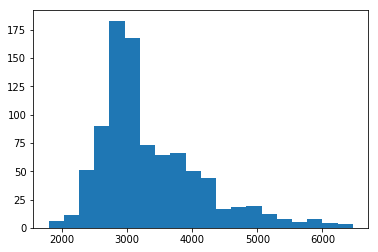

In [7]:
area_num, bin_edges_area, nope = plt.hist(area_A, 20)
area_cond_min, area_cond_max = bin_edges_area[np.argmax(area_num)], bin_edges_area[np.argmax(area_num)+1]

In [8]:
# smoothing
wvp_rolled_sm_A = np.copy(wvp_rolled_A)
for i in range(np.shape(wvp_rolled_A)[0]):
    wvp_rolled_sm_A[i] = gaussian_filter(wvp_rolled_A[i,:,:], sigma = 3)

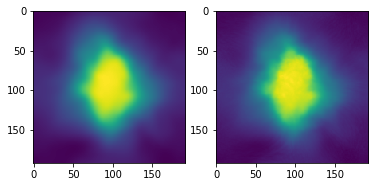

In [9]:
plt.subplot(121)
plt.imshow(wvp_rolled_sm_A[-1,:,:])
plt.title('smoothed field')
plt.subplot(122)
plt.imshow(wvp_rolled_A[-1,:,:])
plt.title('unsmoothed field')

In [12]:
# Condition on edge and center

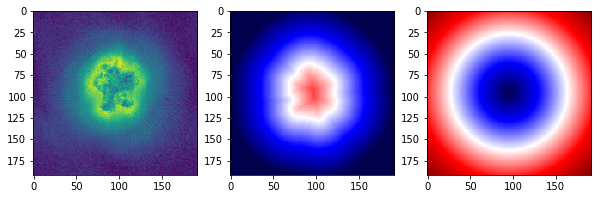

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(v_h_abs_rolled_A[-10,:,:])
plt.subplot(132)
plt.imshow(distance_A[-10,:,:], cmap = 'seismic', vmin = -200, vmax = 200)
plt.subplot(133)
plt.imshow(distance_center, cmap = 'seismic')

Flatten data and condition on the area

In [15]:
distance_flat = np.ndarray.flatten(distance_A[np.where((area_A>area_cond_min)&(area_A<area_cond_max))])
distance_center_flat = np.ndarray.flatten(np.multiply(np.ones(np.shape(v_h_abs_rolled_A[np.where((area_A>area_cond_min)&(area_A<area_cond_max))])), distance_center*dx))
v_h_abs_flat = np.ndarray.flatten(v_h_abs_rolled_A[np.where((area_A>area_cond_min)&(area_A<area_cond_max))])
wvp_flat = np.ndarray.flatten(wvp_rolled_A[np.where((area_A>area_cond_min)&(area_A<area_cond_max))])
r_flat   = np.ndarray.flatten(r_rolled_A[np.where((area_A>area_cond_min)&(area_A<area_cond_max))])
wvp_sm_flat = np.ndarray.flatten(wvp_rolled_sm_A[np.where((area_A>area_cond_min)&(area_A<area_cond_max))])

Mean relationships

(0.01, 0.61)

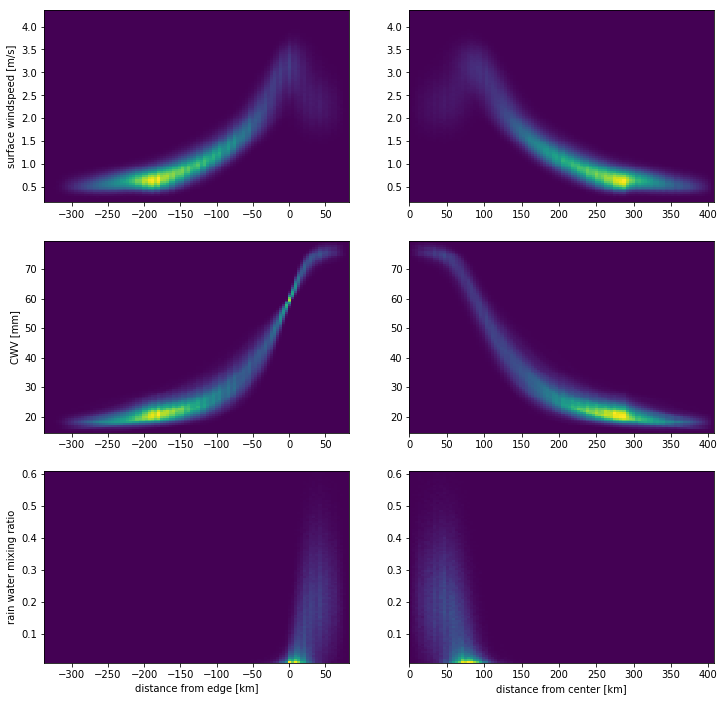

In [59]:
plt.figure(figsize=(12,12))

nbins = 100

plt.subplot(321)
hist2d_edge, xedges_edge, yedges_edge, nope = plt.hist2d(distance_flat, v_h_abs_flat, nbins, cmap = 'viridis')
plt.ylabel('surface windspeed [m/s]')
plt.subplot(322)
hist2d_center, xedges_center, yedges_center, nope = plt.hist2d(distance_center_flat, v_h_abs_flat, nbins, cmap = 'viridis')

plt.subplot(323)
hist2d_edge, xedges_edge, yedges_edge, nope = plt.hist2d(distance_flat, wvp_sm_flat, nbins, cmap = 'viridis')
plt.ylabel('CWV [mm]')
plt.subplot(324)
hist2d_center, xedges_center, yedges_center, nope = plt.hist2d(distance_center_flat, wvp_sm_flat, nbins, cmap = 'viridis')

plt.subplot(325)
hist2d_edge, xedges_edge, yedges_edge, nope = plt.hist2d(distance_flat, r_flat*1e3, (nbins, np.linspace(0.01, 0.61, nbins)), cmap = 'viridis')
plt.ylabel('rain water mixing ratio')
plt.xlabel('distance from edge [km]')
plt.ylim(0.01, 0.61)
plt.subplot(326)
hist2d_center, xedges_center, yedges_center, nope = plt.hist2d(distance_center_flat, r_flat*1e3, (nbins, np.linspace(0.01, 0.61, nbins)), cmap = 'viridis')
plt.xlabel('distance from center [km]')
plt.ylim(0.01, 0.61)

## i) Surface wind speed

In [64]:
min_edge, min_center = -20, 100 #Note: want to measure outside of the aggregation cluster where surface wind really points towards the moist cluster
DX = 20

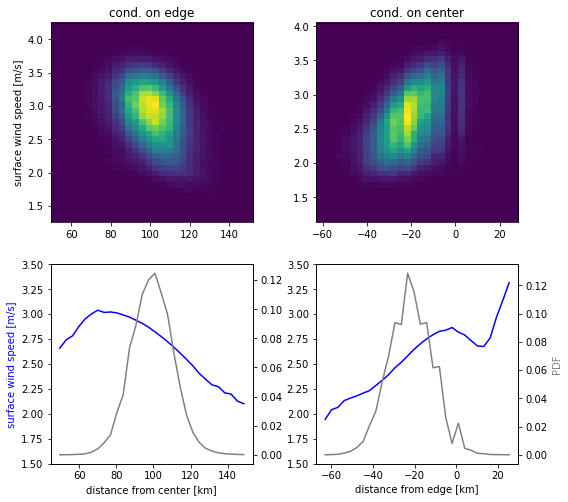

In [62]:
plt.figure(figsize=(8,10))
edge_cond = np.where((distance_flat<min_edge+DX) & (distance_flat > min_edge))
center_cond = np.where((distance_center_flat<min_center+DX) & (distance_center_flat>min_center))
plt.subplot(321)
nope = plt.hist2d(distance_center_flat[edge_cond], v_h_abs_flat[edge_cond], (30,35))
plt.title('cond. on edge')
plt.ylabel('surface wind speed [m/s]')
plt.subplot(322)
nope2 = plt.hist2d(distance_flat[center_cond], v_h_abs_flat[center_cond], (30,35))
plt.title('cond. on center')

plt.subplot(323)
plt.plot(nope[1][:-1], np.sum(nope[0].T*nope[2][:-1][:,None], axis = 0)/np.sum(nope[0].T, axis = 0), color = 'blue')
plt.ylim(1.5, 3.5)
plt.xlabel('distance from center [km]')
plt.ylabel('surface wind speed [m/s]', color = 'blue')
ax1 = plt.gca()
ax2 = plt.twinx()
ax2.plot(nope[1][:-1], np.sum(nope[0].T, axis = 0)/np.sum(nope[0].T), 'grey')
plt.subplot(324)
plt.plot(nope2[1][:-1], np.sum(nope2[0].T*nope2[2][:-1][:,None], axis = 0)/np.sum(nope2[0].T, axis = 0), color = 'blue')
plt.xlabel('distance from edge [km]')
plt.ylim(1.5, 3.5)
ax1 = plt.gca()
ax2 = plt.twinx()
ax2.plot(nope2[1][:-1], np.sum(nope2[0].T, axis = 0)/np.sum(nope2[0].T), 'grey')
plt.ylabel('PDF', color = 'grey')
plt.tight_layout()

Result: surface wind decreases with increasing distance of the edge from the center, i.e. surface wind speed will push less hard against protruding features; surface wind can therefore not explain surface minimization 

## ii) Deep convection/CWV

In [72]:
min_edge2, min_center2 = 20, 60 #Note: want to measure inside the aggregation cluster where we actually have deep convection

edge_cond = np.where((distance_flat<min_edge2+DX) & (distance_flat>min_edge2))
center_cond = np.where((distance_center_flat<min_center2+DX) & (distance_center_flat>min_center2))

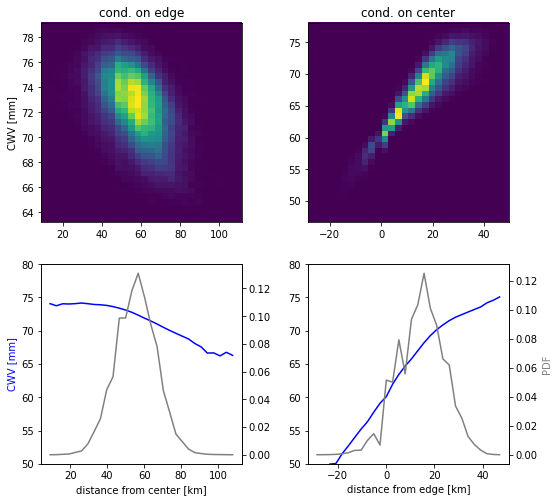

In [73]:
plt.figure(figsize=(8,10))

plt.subplot(321)
nope = plt.hist2d(distance_center_flat[edge_cond], wvp_sm_flat[edge_cond], (30,35))
plt.title('cond. on edge')
plt.ylabel('CWV [mm]')
plt.subplot(322)
nope2 = plt.hist2d(distance_flat[center_cond], wvp_sm_flat[center_cond], (30,35))
plt.title('cond. on center')

plt.subplot(323)
plt.plot(nope[1][:-1], np.sum(nope[0].T*nope[2][:-1][:,None], axis = 0)/np.sum(nope[0].T, axis = 0), color = 'blue')
plt.ylim(50, 80)
plt.xlabel('distance from center [km]')
plt.ylabel('CWV [mm]', color = 'blue')
ax1 = plt.gca()
ax2 = plt.twinx()
ax2.plot(nope[1][:-1], np.sum(nope[0].T, axis = 0)/np.sum(nope[0].T), 'grey')
plt.subplot(324)
plt.plot(nope2[1][:-1], np.sum(nope2[0].T*nope2[2][:-1][:,None], axis = 0)/np.sum(nope2[0].T, axis = 0), color = 'blue')
plt.xlabel('distance from edge [km]')
plt.ylim(50, 80)
ax1 = plt.gca()
ax2 = plt.twinx()
ax2.plot(nope2[1][:-1], np.sum(nope2[0].T, axis = 0)/np.sum(nope2[0].T), 'grey')
plt.ylabel('PDF', color = 'grey')
plt.tight_layout()

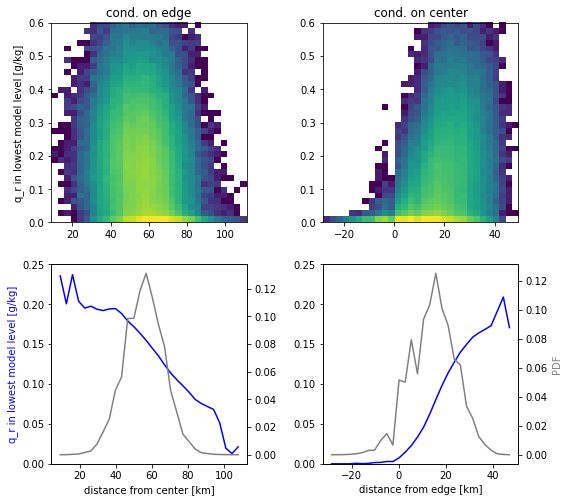

In [74]:
plt.figure(figsize=(8,10))

plt.subplot(321)
nope = plt.hist2d(distance_center_flat[edge_cond], r_flat[edge_cond]*1e3, (30, np.linspace(0.00, 0.60, 35)), norm=colors.LogNorm())
plt.title('cond. on edge')
plt.ylabel('q_r in lowest model level [g/kg]')
plt.subplot(322)
nope2 = plt.hist2d(distance_flat[center_cond], r_flat[center_cond]*1e3, (30, np.linspace(0.00, 0.60, 35)), norm=colors.LogNorm())
plt.title('cond. on center')

plt.subplot(323)
plt.plot(nope[1][:-1], np.sum(nope[0].T*nope[2][:-1][:,None], axis = 0)/np.sum(nope[0].T, axis = 0), color = 'blue')
plt.ylim(0.0, 0.25)
plt.xlabel('distance from center [km]')
plt.ylabel('q_r in lowest model level [g/kg]', color = 'blue')
ax1 = plt.gca()
ax2 = plt.twinx()
ax2.plot(nope[1][:-1], np.sum(nope[0].T, axis = 0)/np.sum(nope[0].T), 'grey')
plt.subplot(324)
plt.plot(nope2[1][:-1], np.sum(nope2[0].T*nope2[2][:-1][:,None], axis = 0)/np.sum(nope2[0].T, axis = 0), color = 'blue')
plt.xlabel('distance from edge [km]')
plt.ylim(0.0, 0.25)
ax1 = plt.gca()
ax2 = plt.twinx()
ax2.plot(nope2[1][:-1], np.sum(nope2[0].T, axis = 0)/np.sum(nope2[0].T), 'grey')
plt.ylabel('PDF', color = 'grey')
plt.tight_layout()

Result: We have drier conditions/less deep convection if the edge is further from the center; i.e. surface tension analogy works: 

Analogous to the surface tension at the interface between water  and  air,  which  results  from  the  larger  attraction  of water molecules to other water molecules rather than airmolecules, the aggregation of moist regions results from the  increased  likelihood  of  deep  convection  to  occur  in the moist environment of other deep convective updrafts rather  than  in  the  drier  surrounding. The  net  effect  of this attraction between deep convective updrafts is an inward directed force at the boundary of the moist tropics which acts to minimize the surface.